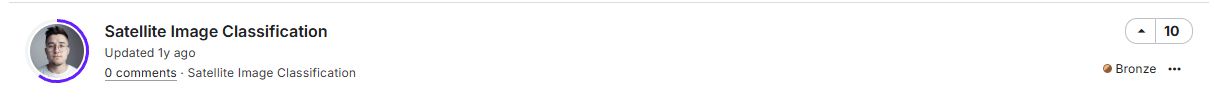

In [1]:
import pandas as pd
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image

sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess

from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input as resnet101_preprocess

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess

from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input as densenet201_preprocess

from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as inceptionresnetv2_preprocess

import warnings
warnings.filterwarnings('ignore')

ImportError: SciKeras requires TensorFlow >= 2.7.0.

In [ ]:
root_dir = "/kaggle/input/satellite-image-classification/data/"

2.4.0


In [2]:
folders = os.listdir(root_dir)
folders

NameError: name 'os' is not defined

In [3]:
def read_data(folder):
    data, labels, paths = [], [], []
    for label in folders:
        path = f"{folder}/{label}/"
        folder_data = os.listdir(path)
        for image_path in folder_data:
            #print(path + image_path)
            img = cv2.imread(path + image_path)
            img = cv2.resize(img, (224, 224))
            data.append(np.array(img))
            labels.append(label)
            paths.append(os.path.join(root_dir, label, image_path))

    return data, labels, paths

In [4]:
all_data, all_labels, all_paths = read_data(root_dir)

NameError: name 'root_dir' is not defined

In [5]:
df = pd.DataFrame({'data': all_data, 'label': all_labels, 'path': all_paths})

NameError: name 'pd' is not defined

In [6]:
df_train, df_valid, df_test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

print("Train Size: ", df_train.shape[0])
print("valid Size: ", df_valid.shape[0])
print("Test Size: ", df_test.shape[0])

NameError: name 'np' is not defined

In [7]:
plt.figure(figsize=(10, 8))
ax = sns.countplot(y="label", order=df_train["label"].value_counts().index, data=df_train)
ax.set_title("Train - Categories")
for container in ax.containers:
    ax.bar_label(container)

NameError: name 'plt' is not defined

In [8]:
plt.figure(figsize=(10, 8))
ax = sns.countplot(y="label", order=df_valid["label"].value_counts().index, data=df_valid)
ax.set_title("Valid - Categories")
for container in ax.containers:
    ax.bar_label(container)

NameError: name 'plt' is not defined

In [9]:
plt.figure(figsize=(10, 8))
ax = sns.countplot(y="label", order=df_test["label"].value_counts().index, data=df_test)
ax.set_title("Test - Categories")
for container in ax.containers:
    ax.bar_label(container)

NameError: name 'plt' is not defined

In [10]:
def visualize_df(df: np.ndarray):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))

    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            a = np.random.randint(1, len(df), 1)[0]
            img_path = df.loc[a][['path']].values[0]
            img_label = df.loc[a][['label']].values[0]
            
            image = Image.open(img_path).convert('RGB')
            
            ax.imshow(image)
            ax.set_title(img_label)
            ax.axis('off')
            
        else:
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

NameError: name 'np' is not defined

In [11]:
visualize_df(df)

NameError: name 'visualize_df' is not defined

In [12]:
train_data =  np.array([np.array(val) for val in df_train['data'].values])
valid_data = np.array([np.array(val) for val in df_valid['data'].values])
test_data = np.array([np.array(val) for val in df_test['data'].values])

NameError: name 'np' is not defined

In [13]:
le = LabelEncoder()
train_labels = le.fit_transform(df_train['label'])
valid_labels = le.transform(df_valid['label'])
test_labels = le.transform(df_test['label'])

NameError: name 'LabelEncoder' is not defined

In [14]:
train_labels = to_categorical(train_labels)
valid_labels = to_categorical(valid_labels)
test_labels = to_categorical(test_labels)

NameError: name 'to_categorical' is not defined

In [ ]:
scores_df = pd.DataFrame(columns=['Model Name', 'Accuracy', 'Loss'])
scores_df

In [ ]:
num_classes = len(folders)
print(num_classes)

In [ ]:
def train_tl_model(models, preprocessors):
    for model_name, preprocess_func in zip(models, preprocessors):
        print()
        print(f' {model_name.__name__} '.center(50, '#'))
        input_layer = tf.keras.Input((224, 224, 3))
        preprocessed_inputs = tf.keras.layers.Lambda(lambda x: preprocess_func(x))(input_layer)
        base_model = model_name(weights='imagenet', include_top=False, input_tensor=preprocessed_inputs)
        for layer in base_model.layers:
            layer.trainable = False
        inputs = base_model.input
        x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
        #x = tf.keras.layers.Dense(512, activation='relu')(base_model.output)
        #x = tf.keras.layers.Dense(256, activation='relu')(x)
        outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
        model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='val_loss', patience=3)
        history = model.fit(train_data, train_labels, validation_data=(valid_data, valid_labels), epochs=50, batch_size=64, callbacks=[early_stopping], verbose=0)

        fig, axes = plt.subplots(1, 2, figsize=(12, 3))
        ax = axes.ravel()

        for i, metric in enumerate(['accuracy', 'loss']):
            ax[i].plot(history.history[metric])
            ax[i].plot(history.history['val_' + metric])
            ax[i].set_xlabel('Epoch')
            ax[i].set_ylabel(metric)
            ax[i].legend(['train', 'valid'])

        plt.show()

        results = model.evaluate(test_data, test_labels, verbose=0)
        print(f'Test Loss: {results[0]}')
        print(f'Test Accuracy: {results[1]}')

        scores_df.loc[len(scores_df)] = [model_name.__name__, results[0], results[1]]

        print(' '.center(50, '#'))
        print()

In [ ]:
models = [VGG16, VGG19, ResNet50, ResNet101, MobileNet, DenseNet201, Xception, InceptionResNetV2]

preprocessors = [vgg16_preprocess, vgg19_preprocess, resnet50_preprocess, resnet101_preprocess, mobilenet_preprocess,
                 densenet201_preprocess, xception_preprocess, inceptionresnetv2_preprocess]

In [ ]:
train_tl_model(models, preprocessors)

In [ ]:
def create_model(units=16, lr_rate=0.1):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
units = [16, 32]
lr_rate = [0.1,0.001]
batch_size = [128, 64]

In [ ]:
keras_model = KerasClassifier(build_fn=create_model, units=units, lr_rate=lr_rate, epochs=10, 
                              batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=3)], verbose=0)

In [ ]:
param_grid = dict(units = units, lr_rate = lr_rate, batch_size = batch_size)

In [ ]:
grid = GridSearchCV(estimator = keras_model, param_grid = param_grid, cv = 3)
grid_result = grid.fit(train_data, train_labels)

In [ ]:
print("The best parameters are:",grid_result.best_params_)
best_params = grid_result.best_params_

In [ ]:
print(f' DNN '.center(50, '#'))
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(best_params["units"], activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params["lr_rate"]),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_data, train_labels, validation_data=(valid_data, valid_labels), epochs=50, batch_size=best_params["batch_size"], callbacks=[early_stopping], verbose=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
ax = axes.ravel()

for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history['val_' + metric])
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'valid'])

plt.show()

results = model.evaluate(test_data, test_labels, verbose=0)
print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

scores_df.loc[len(scores_df)] = ["DNN", results[0], results[1]]

print(' '.center(50, '#'))
print()

In [ ]:
def plot_scores(df):
    plt.figure(figsize=(15, 20))

    plt.subplot(211)
    ax = sns.barplot(data=df, x='Model Name', y="Accuracy", palette='viridis')
    for container in ax.containers:
        ax.bar_label(container)

    plt.xlabel('')
    plt.xticks(rotation=45)
    plt.title("Model / Test Accuracy")

    plt.subplot(212)
    ax = sns.barplot(data=df, x='Model Name', y="Loss", palette='viridis')
    for container in ax.containers:
        ax.bar_label(container)

    plt.xlabel('')
    plt.xticks(rotation=45)
    plt.title("Model / Test Loss")

    plt.show()

In [ ]:
plot_scores(scores_df)